In [ ]:
from keras import models
from keras.models import load_model

In [ ]:
!sudo pip3 install mtcnn

In [ ]:
import os
from PIL import *
from numpy import asarray
from matplotlib import pyplot
from mtcnn.mtcnn import MTCNN
import numpy

In [ ]:
def extract_face(filename, required_size=(160, 160)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

In [ ]:
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in os.listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path)
		# store
		faces.append(face)
	return faces

In [ ]:
# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in os.listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not os.path.isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)

In [ ]:
# load train dataset
trainX, trainy = load_dataset('/content/drive/MyDrive/metest/Dataset_celeb_small/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/drive/MyDrive/metest/Dataset_celeb_small/val/')
print(testX.shape, testy.shape)
# save arrays to one file in compressed format
#savez_compressed('/content/drive/MyDrive/metest/data/5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 21 examples for class: jerry_seinfeld
>loaded 17 examples for class: elton_john
>loaded 19 examples for class: madonna
>loaded 14 examples for class: ben_afflek
>loaded 22 examples for class: mindy_kaling
(93, 160, 160, 3) (93,)
>loaded 5 examples for class: elton_john
>loaded 5 examples for class: madonna
>loaded 5 examples for class: ben_afflek
>loaded 5 examples for class: mindy_kaling
>loaded 5 examples for class: jerry_seinfeld
(25, 160, 160, 3) (25,)


In [ ]:
numpy.savez_compressed('/content/drive/MyDrive/metest/Dataset_celeb_small/5-celebrity-faces-dataset.npz', trainX, trainy, testX, testy)

In [ ]:
# load the face dataset
data = numpy.load('/content/drive/MyDrive/metest/Dataset_celeb_small/5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Loaded: ', trainX.shape, trainy.shape, testX.shape, testy.shape)

Loaded:  (93, 160, 160, 3) (93,) (25, 160, 160, 3) (25,)


In [ ]:
# load the facenet model
model = load_model('/content/drive/MyDrive/metest/Copy of facenet_keras.h5')
print('Loaded Model')

Loaded Model


In [ ]:
def get_embedding(model, face_pixels):
	# scale pixel values
	face_pixels = face_pixels.astype('float32')
	# standardize pixel values across channels (global)
	mean, std = face_pixels.mean(), face_pixels.std()
	face_pixels = (face_pixels - mean) / std
	# transform face into one sample
	samples = numpy.expand_dims(face_pixels, axis=0)
	# make prediction to get embedding
	yhat = model.predict(samples)
	return yhat[0]
 

In [ ]:
# convert each face in the train set to an embedding
newTrainX = list() 
for face_pixels in trainX:
	embedding = get_embedding(model, face_pixels)
	newTrainX.append(embedding)
newTrainX = asarray(newTrainX)
print(newTrainX.shape)

(93, 128)


In [ ]:
# convert each face in the test set to an embedding
newTestX = list()
for face_pixels in testX:
	embedding = get_embedding(model, face_pixels)
	newTestX.append(embedding)
newTestX = asarray(newTestX)
print(newTestX.shape)
# save arrays to one file in compressed format
numpy.savez_compressed('/content/drive/MyDrive/metest/Dataset_celeb_small/5-celebrity-faces-dataset.npz', newTrainX, trainy, newTestX, testy)

(25, 128)


In [ ]:
# load dataset
data = numpy.load('/content/drive/MyDrive/metest/Dataset_celeb_small/5-celebrity-faces-dataset.npz')
trainX, trainy, testX, testy = data['arr_0'], data['arr_1'], data['arr_2'], data['arr_3']
print('Dataset: train=%d, test=%d' % (trainX.shape[0], testX.shape[0]))

Dataset: train=93, test=25


In [ ]:
from sklearn import preprocessing
from sklearn import svm, metrics

In [ ]:
# normalize input vectors
in_encoder = preprocessing.Normalizer(norm='l2')
trainX = in_encoder.transform(trainX)
testX = in_encoder.transform(testX)

In [ ]:
# label encode targets
out_encoder = preprocessing.LabelEncoder()
out_encoder.fit(trainy)
trainy = out_encoder.transform(trainy)
testy = out_encoder.transform(testy)

In [ ]:
# fit model
model = svm.SVC(kernel='linear', probability=True, max_iter = 100, verbose=True)
model.fit(trainX, trainy)

[LibSVM]

SVC(kernel='linear', max_iter=100, probability=True, verbose=True)

In [ ]:
# predict
yhat_train = model.predict(trainX)
yhat_test = model.predict(testX)
# score
score_train = metrics.accuracy_score(trainy, yhat_train)
score_test = metrics.accuracy_score(testy, yhat_test)
# summarize
print('Accuracy: train=%.3f, test=%.3f' % (score_train*100, score_test*100))

Accuracy: train=100.000, test=100.000


In [ ]:
from sklearn.datasets import make_circles
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
confusion_matrix(testy, yhat_test)

array([[5, 0, 0, 0, 0],
       [0, 5, 0, 0, 0],
       [0, 0, 5, 0, 0],
       [0, 0, 0, 5, 0],
       [0, 0, 0, 0, 5]])

In [ ]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(testy, yhat_test)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(testy, yhat_test,average = "macro")
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(testy, yhat_test, average = "macro" )
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(testy, yhat_test, average = "macro")
print('F1 score: %f' % f1)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000


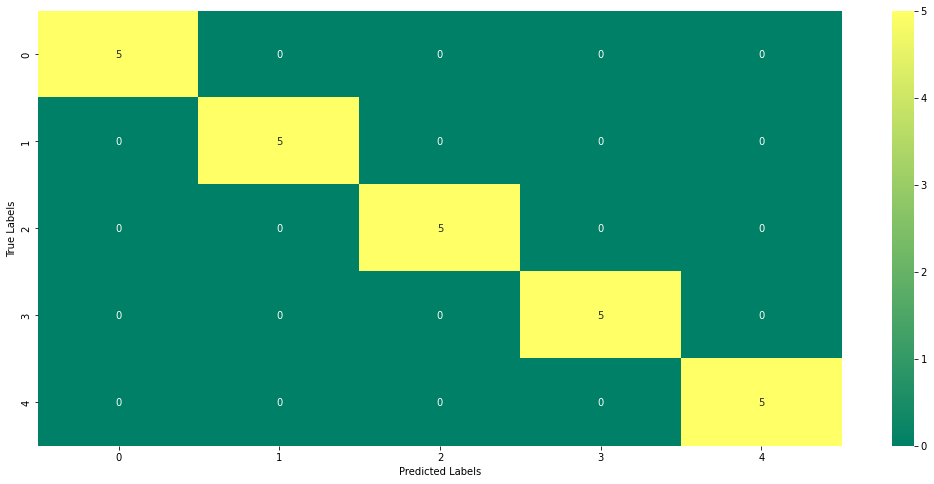

In [ ]:
plt.figure(figsize = (18,8))
sns.heatmap(metrics.confusion_matrix(testy, yhat_test), annot = True, xticklabels = numpy.unique(testy), yticklabels = numpy.unique(yhat_test), cmap = 'summer')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
import numpy as np
from sklearn.datasets import load_digits
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

In [ ]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]

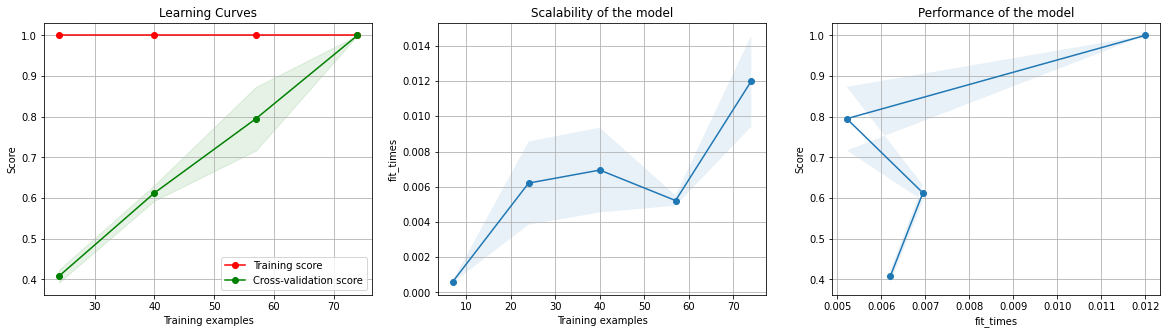

In [ ]:
#plot graph
X, y = load_digits(return_X_y=True)
title = r"Learning Curves"
plot_learning_curve(
    model, title, trainX, trainy
)

plt.show()